### Marie Ernst (Matrikelnummer: 11590905)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor

ModuleNotFoundError: No module named 'sklearn'

# Daten einlesen

In [2]:
# Laden des Datensatzes
data_cleaned = "../data/cleaned_train.csv"
data = pd.read_csv(data_cleaned, delimiter=",", encoding="latin", header=0, thousands=",", decimal='.', low_memory=False)

## Features

### Lag-Feature

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit

# RMSPE Funktion definieren
def rmspe(y_true, y_pred):
    y_pred = np.array(y_pred)  # Umwandlung der Vorhersagen in ein Numpy-Array
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    return np.sqrt(np.mean(((y_true_filtered - y_pred_filtered) / y_true_filtered) ** 2))

# RMSPE als Scorer definieren
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

# Laden des Datensatzes
data_cleaned = "../data/cleaned_train_alt.csv"
data = pd.read_csv(data_cleaned, delimiter=",", encoding="latin", header=0, thousands=",", decimal='.', low_memory=False)

# Zielvariable und Features definieren
X = data.drop('Sales', axis=1)
y = data['Sales']

# Definiere die numerischen und kategorischen Features
numerical_features = ['year', 'month', 'day', 'week_of_year', 'lag_1', 'lag_7']
already_encoded_features = ['Open', 'Promo', 'promo2']
categorical_features_to_encode = ['Store', 'DayOfWeek', 'StoreType', 'StateHoliday', 'Assortment']

# Preprocessing Pipeline für numerische und kategorische Features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('enc', 'passthrough', already_encoded_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_to_encode)
    ])

# Modell für RandomForest erstellen
model = RandomForestRegressor(n_estimators=1, random_state=42)

# Pipeline erstellen
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

#Funktion zur Vorhersage der nächsten x Tage (wie im Originalcode)
def predict_multiple_days_with_updates(X_last, test_data, num_days):
    predictions = []
    X_next = X_last.copy()
    X_next = pd.DataFrame([X_next])  # In DataFrame umwandeln
    last_lags = list(X_last[['lag_1']].values.flatten())  # Initialisiere letzte Lags

    for day in range(num_days):
        # Preprocess die Daten vor der Vorhersage
        X_next_preprocessed = pipeline.named_steps['preprocessor'].transform(X_next)
        
        # Vorhersage des nächsten Tages
        y_next_pred = pipeline.named_steps['model'].predict(X_next_preprocessed)[0]
        predictions.append(y_next_pred)

        # Aktualisiere die Lag-Features basierend auf der Vorhersage
        last_lags.append(y_next_pred)
        last_lags.pop(0)  # Aktualisiere Lag-Werte

        X_next.loc[:, 'lag_1'] = y_next_pred
        X_next.loc[:, 'lag_7'] = last_lags[0]

        # Aktualisiere andere Features (Tag, Monat, Woche)
        X_next.loc[:, 'day'] += 1
        if X_next.loc[:, 'day'].values[0] > 31:
            X_next.loc[:, 'day'] = 1
            X_next.loc[:, 'month'] += 1
        if X_next.loc[:, 'month'].values[0] > 12:
            X_next.loc[:, 'month'] = 1
            X_next.loc[:, 'year'] += 1

        X_next.loc[:, 'week_of_year'] = (X_next['week_of_year'] % 52) + 1
        X_next.loc[:, 'DayOfWeek'] = (X_next['DayOfWeek'] % 7) + 1

        # Promo- und andere Features aus Testdaten übernehmen
        if day < len(test_data):
            X_next.loc[:, 'Promo'] = test_data.iloc[day]['Promo']
            X_next.loc[:, 'Open'] = test_data.iloc[day]['Open']
            X_next.loc[:, 'StateHoliday'] = test_data.iloc[day]['StateHoliday']

    return predictions

# TimeSeriesSplit für Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

# Überprüfung mit Cross-Validation
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

cv_rmspe_scores = []
for train_idx, test_idx in tscv.split(X_train):
    X_train_cv, X_test_cv = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_cv, y_test_cv = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # Pipeline auf den Cross-Validation-Trainingsdaten fitten
    pipeline.fit(X_train_cv, y_train_cv)

    # Lag-Feature-Vorhersage für die CV-Testdaten
    X_last_cv = X_test_cv.iloc[0]  # Starte mit dem ersten Testtag
    num_days_cv = len(X_test_cv)    # Vorhersage für alle Testtage
    future_predictions_cv = predict_multiple_days_with_updates(X_last_cv, X_test_cv, num_days_cv)

    # Berechne RMSPE für diesen Split
    rmspe_score = rmspe(y_test_cv.values, future_predictions_cv)
    cv_rmspe_scores.append(rmspe_score)

# Ausgabe der Ergebnisse
mean_cv_rmspe = np.mean(cv_rmspe_scores)
print(f"Durchschnittliche RMSPE (Cross-Validation): {mean_cv_rmspe:.4f}")

# Nimm die letzten Daten als Startpunkt für die Vorhersage
X_last = X_test.iloc[-60]

# Vorhersage für die nächsten 7 Tage unter Verwendung von Promo-Informationen aus dem Testdatensatz
num_days = 60
test_data_next_days = X_test.iloc[:num_days]  # Extrahiere die Testdaten für die nächsten Tage

# Vorhersagen für die nächsten Tage machen
future_predictions = predict_multiple_days_with_updates(X_last, test_data_next_days, num_days)

# Ergebnisse anzeigen
print(f"Vorhersagen für die nächsten {num_days} Tage:", future_predictions)

# Tatsächliche Verkaufszahlen für die nächsten 7 Tage aus dem Testdatensatz extrahieren
actual_sales_next_days = y_test.iloc[:num_days].values

# Berechnung der RMSPE für die Vorhersagen
prediction_rmspe = rmspe(actual_sales_next_days, future_predictions)

# Ergebnis anzeigen
print(f"RMSPE der Vorhersagen für die nächsten {num_days} Tage: {prediction_rmspe:.4f}")

Durchschnittliche RMSPE (Cross-Validation): 1.7539
Vorhersagen für die nächsten 60 Tage: [6868.0, 6235.0, 5694.0, 0.0, 0.0, 9615.0, 8180.0, 6480.0, 6328.0, 5470.0, 0.0, 4090.0, 3776.0, 3756.0, 3973.0, 3476.0, 3169.0, 0.0, 9615.0, 10744.0, 10041.0, 8735.0, 9165.0, 8373.0, 0.0, 15301.0, 25107.0, 16837.0, 18127.0, 16058.0, 16077.0, 0.0, 8324.0, 8328.0, 8328.0, 6355.0, 6594.0, 6588.0, 0.0, 4090.0, 3646.0, 3309.0, 2723.0, 3333.0, 2685.0, 0.0, 9615.0, 10311.0, 10216.0, 8735.0, 9165.0, 8373.0, 0.0, 4090.0, 3646.0, 3309.0, 2930.0, 3848.0, 4086.0, 0.0]
RMSPE der Vorhersagen für die nächsten 60 Tage: 0.9235


Aufgrund der schlechten performance des Modells bei der Verwendung der Lag-Features, haben wir uns dazu entschlossen diese wegzulassen, auch wenn sie bei ersten Untersuchungen eine hohe Korrealtion mit den Verkäufen aufgewiesen haben.

In [3]:
# Definiere die numerischen und kategorischen Features
numerical_features = ['year', 'month', 'day', 'week_of_year', 'fourier_sin_365', 'fourier_cos_365',	'days_since_last_holiday',	'days_until_next_holiday'] # lag_1, lag_7 entfernt

# Bereits encodierte Features
already_encoded_features = ['Promo', 'promo2']

# Noch nicht encodierte kategorische Features
categorical_features_to_encode = ['DayOfWeek', 'StoreType', 'StateHoliday','Assortment', 'Store']

Die Zeitmerkmale Jahr, Monat, Tag und Woche des Jahres helfen dabei, saisonale Trends und zeitabhängige Muster zu erfassen. Verkäufe variieren häufig in bestimmten Monaten oder Jahreszeiten, was die Vorhersagegenauigkeit deutlich erhöht. Die Verwendung von Fourier-Transformationen, speziell die Fourier-Sin- und Fourier-Cos-Funktionen für 365 Tage, ermöglicht es, saisonale Effekte auf kontinuierliche Weise zu modellieren. Diese Features sind besonders nützlich, um komplexe saisonale Muster zu identifizieren und verbessern die Robustheit der Vorhersagen.
Die Merkmale `days_since_last_holiday` und `days_until_next_holiday` `wurden gewählt, da Feiertage oft einen signifikanten Einfluss auf die Verkaufszahlen haben. Diese zeitlichen Angaben helfen dem Modell, den Einfluss von Feiertagen auf den Verkauf in den relevanten Zeiträumen zu erfassen.

`Promo` und `Promo2` geben an, ob während bestimmter Zeiträume Werbeaktionen durchgeführt werden. Promotionen haben häufig einen erheblichen Einfluss auf die Verkaufszahlen, und die Berücksichtigung dieser Merkmale ermöglicht es dem Modell, den Effekt von Rabatten auf die Verkaufsprognosen zu lernen.

Verkaufszahlen variieren oft an verschiedenen Wochentagen, und die Codierung des Features `day_of_the_week` erlaubt es dem Modell, wöchentliche Muster zu erkennen. Das `StoreType`-Feature ist relevant, da die Art des Geschäfts einen Einfluss auf die Verkaufszahlen haben kann. Unterschiedliche Geschäftsmodelle ziehen unterschiedliche Kunden an und verfolgen variierende Verkaufsstrategien.

Ein weiteres wichtiges Feature ist `StateHoliday`, das angibt, ob ein Feiertag vorliegt. Feiertage haben oft einen starken Einfluss auf den Einzelhandel, und das Modell kann lernen, diese Effekte zu berücksichtigen. Das `Assortment`-Feature, das die Produktvielfalt im Geschäft beschreibt, ist ebenfalls entscheidend, da unterschiedliche Sortimentstypen verschiedene Kunden anziehen und die Verkaufszahlen beeinflussen können. Schließlich liefert das `Store`-Feature Informationen über spezifische Geschäfte, was hilft, lokale Verkaufsunterschiede zu erfassen. Jedes Geschäft kann unterschiedliche Verkaufsleistungen aufweisen, die durch Faktoren wie Lage, Größe und Zielgruppe bedingt sind.

## Split

In [4]:
# Datensatz sortieren, falls nicht bereits geschehen (angenommen, du hast eine Spalte 'Date')
data = data.sort_values('Date')

data = data[data ['Open']!=0]
data = data[data ['Sales']>0]
#data = data[data ['StateHoliday']!=1]

# Zielvariable und Features definieren
X = data.drop(['Sales', 'Open'], axis=1)  # 'Date' wird entfernt, wenn es keine erklärende Variable ist
y = data['Sales']


# Berechnung der Anzahl der Testdaten (20 % des Datensatzes)
test_size = int(len(data) * 0.2)

# Aufteilen der Daten in Trainings- und Testdaten
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

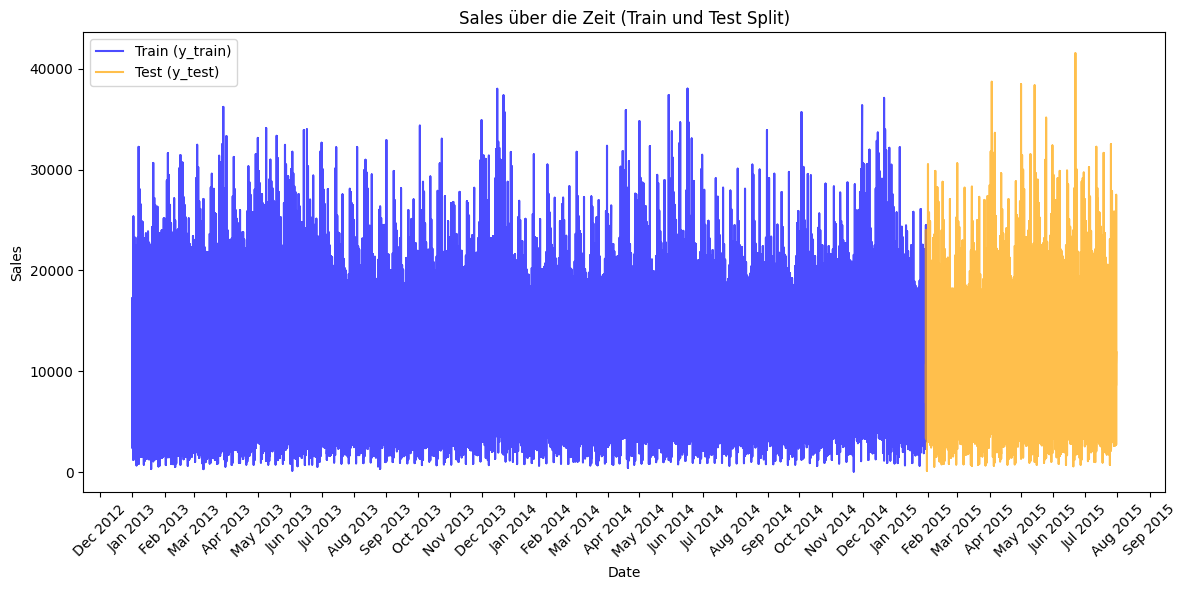

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Konvertiere die 'Date'-Spalte in datetime mit der .loc Methode
X_train.loc[:, 'Date'] = pd.to_datetime(X_train['Date'], errors='coerce')
X_test.loc[:, 'Date'] = pd.to_datetime(X_test['Date'], errors='coerce')

# Liniendiagramm erstellen, um die wahren Sales in y_train und y_test zu visualisieren
plt.figure(figsize=(12, 6))

# Plot für die Trainingsdaten (y_train)
plt.plot(X_train['Date'], y_train, label='Train (y_train)', color='blue', alpha=0.7)

# Plot für die Testdaten (y_test)
plt.plot(X_test['Date'], y_test, label='Test (y_test)', color='orange', alpha=0.7)

# Achsenbeschriftungen
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales über die Zeit (Train und Test Split)')

# X-Achse mit Datumsformatierung (Monat und Jahr)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)  # Drehe die x-Achsenbeschriftung für bessere Lesbarkeit

# Legende
plt.legend()

# Layout anpassen und Diagramm anzeigen
plt.tight_layout()
plt.show()

## Metrik

In [5]:
# Angepasste RMSPE-Funktion, die Tage mit 0 Sales ignoriert
def rmspe(y_true, y_pred):
    # Nur Fälle berücksichtigen, bei denen y_true nicht 0 ist
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    return np.sqrt(np.mean(((y_true_filtered - y_pred_filtered) / y_true_filtered) ** 2))

# RMSPE als Scorer definieren
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

## Kreuzvalidierung - Timeseries

In [6]:
from sklearn.model_selection import TimeSeriesSplit
# Zeitreihen-Kreuzvalidierung einrichten
tscv = TimeSeriesSplit(n_splits=5)

## Preprocessing

In [7]:
# Erstelle den Preprocessor für numerische und kategorische Features (ohne Datumsextraktion)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Skalierung für numerische und bereits encodierte Features
        ('enc', 'passthrough', already_encoded_features),  # Bereits encodierte Features durchschleusen (keine weitere Transformation)
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_to_encode)  # Nur noch nicht encodierte Features encodieren
    ])

# ExtraTreesRegressor

Im Kontext der Vorhersage zukünftiger Verkaufszahlen hat sich der **ExtraTreesRegressor** (Extremely Randomized Trees) als vielversprechendes Modell etabliert. Hierbei handelt es sich um ein Ensemble-Lernverfahren, das auf der Idee basiert, mehrere Entscheidungsbäume zu kombinieren, um die Genauigkeit der Vorhersagen zu erhöhen. Laut **Geurts et al. (2006)** zeigt der ExtraTrees-Algorithmus eine höhere Robustheit und Genauigkeit, da er extreme Zufälligkeit bei der Erstellung der Bäume nutzt, was zu einer besseren Generalisierung auf nicht gesehenen Daten führt. Dies ist besonders relevant für Verkaufsprognosen, die oft von vielen variablen Einflussfaktoren abhängen. 
Der ExtraTreesRegressor bietet eine Vielzahl von Vorteilen für die Vorhersage zukünftiger Verkaufszahlen. Seine Fähigkeit zur hohen Zufälligkeit, reduzierte Overfitting-Gefahr und schnellere Berechnungszeit machen ihn zu einer geeigneten Wahl gegenüber dem RandomForestRegressor.

### Vorteile des ExtraTreesRegressor

1. **Extreme Randomisierung**:
   Der ExtraTreesRegressor verwendet bei der Auswahl von Splits in den Entscheidungsbäumen eine hohe Zufälligkeit. Dies bedeutet, dass anstatt die besten Split-Punkte auszuwählen, zufällig Splits ausgewählt werden. **Hastie et al. (2009)** zeigen, dass diese Randomisierung dazu beiträgt, Overfitting zu reduzieren, was in der Praxis zu stabileren Modellen führt, die sich besser auf neue Verkaufsdaten anwenden lassen.

2. **Weniger Rechenaufwand**:
   Da der ExtraTreesRegressor nicht die optimalen Splits sucht, sondern zufällig wählt, ist der Rechenaufwand im Vergleich zum RandomForestRegressor geringer. Laut **Zhou et al. (2014)** kann diese Eigenschaft die Trainingszeit erheblich verkürzen, was besonders in dynamischen Geschäftsumfeldern von Vorteil ist, in denen zeitnahe Entscheidungen getroffen werden müssen.

3. **Robustheit gegenüber Ausreißern**:
   ExtraTreesRegressor ist robuster gegenüber Ausreißern im Vergleich zu RandomForestRegressor, da die hohe Zufälligkeit in der Baumstruktur den Einfluss einzelner Datenpunkte verringert. Dies ist besonders relevant im Verkaufsumfeld, wo Daten häufig durch plötzliche Nachfragespitzen oder Marktveränderungen beeinflusst werden können.

4. **Bessere Performance bei nicht-stationären Daten**:
   Verkaufsdaten sind häufig nicht-stationär und unterliegen saisonalen Schwankungen. ExtraTreesRegressor kann diese Muster besser erfassen, da er in der Lage ist, verschiedene Datenverteilungen während des Trainings zu berücksichtigen. **Biau et al. (2016)** zeigen, dass ExtraTrees in solchen Szenarien häufig eine höhere Genauigkeit bietet.

### Vergleich mit RandomForestRegressor

Obwohl der RandomForestRegressor ebenfalls ein effektives Ensemble-Modell ist, hat der ExtraTreesRegressor mehrere Vorteile, die ihn zur besseren Wahl für Verkaufsprognosen machen. Zum einen neigt der RandomForestRegressor dazu, komplexere Bäume zu erstellen, was zu einem höheren Risiko von Overfitting führen kann. ExtraTrees minimiert dieses Risiko durch seine extreme Randomisierung. Bei der Durchführung des Trainings und Test mit einem RandomForestRegressor deutete dessen Lernkurve auf Overfitting hin (siehe Abbildung 5).
Zum anderen macht die schnellere Trainingszeit des ExtraTreesRegressors ihn zu einer praktischen Wahl in Umgebungen, in denen schnelle Modellanpassungen erforderlich sind.



### Literaturverzeichnis

- Biau, G., & Scornet, E. (2016). A Random Forest Guided Tour. *Test*, 25(2), 197-227.
- Geurts, P., Ernst, D., & Wehenkel, L. (2006). Extremely randomized trees. *Machine Learning*, 63(1), 3-42.
- Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The Elements of Statistical Learning: Data Mining, Inference, and Prediction*. Springer.
- Zhou, Z. H., & Li, M. (2014). Semi-Supervised Learning. *Springer*. 

In [9]:
# Erstellen der Pipeline mit dem aktuellen Wert für n_estimators
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ExtraTreesRegressor(n_estimators=1, random_state=42, n_jobs=-1))
])

In [11]:
pipeline.fit(X_train, y_train)

In [ ]:
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer, verbose=True)
cv_scores

array([-0.33411873, -0.26752424, -0.24069933, -0.20404405, -0.38023414])

In [ ]:
mean_rmspe = -np.mean(cv_scores)
mean_rmspe

-0.28532409753667565

In [ ]:
y_pred = pipeline.predict(X_test)
test_rmspe = rmspe(y_test, y_pred)
test_rmspe

0.2083542867013725

## Feature Importance

Die Analyse der Feature Importance ist ein unverzichtbarer Bestandteil des Modells beim ExtraTreesRegressor. Sie fördert die Interpretierbarkeit des Modells, unterstützt die Datenreduzierung und verbessert die Gesamtleistung. 

Die Identifikation von wichtigen Features erhöht das Verständnis für das Modellverhalten. Laut **Geurts et al. (2006)** können die Ergebnisse der Feature-Importance-Analyse Entscheidungsträgern helfen, fundierte strategische Entscheidungen zu treffen, indem sie auf die Merkmale hinweisen, die den größten Einfluss auf die Vorhersagen haben.

Die Kenntnis der wichtigsten Features ermöglicht es, unwichtige Merkmale zu identifizieren und gegebenenfalls zu entfernen. **Liaw und Wiener (2002)** zeigen, dass dies nicht nur die Berechnungszeit reduziert, sondern auch das Risiko von Overfitting verringert, indem das Modell weniger komplex wird.

Durch die Fokussierung auf die wichtigsten Merkmale können die Vorhersagegenauigkeit und die Generalisierung des Modells verbessert werden. **Biau und Scornet (2016)** haben festgestellt, dass die Eliminierung unwichtiger Features oft zu einer besseren Modellleistung führt.


### Literaturverzeichnis

- Biau, G., & Scornet, E. (2016). A Random Forest Guided Tour. *Test*, 25(2), 197-227.
- Geurts, P., Ernst, D., & Wehenkel, L. (2006). Extremely randomized trees. *Machine Learning*, 63(1), 3-42.
- Liaw, A., & Wiener, M. (2002). Classification and regression by randomForest. *R News*, 2(3), 18-22.

In [15]:
# Angenommen, dein 'preprocessor' ist ein ColumnTransformer
preprocessor = pipeline.named_steps['preprocessor']

# Transformiere die Trainingsdaten, um die Feature-Namen nach der Transformation zu erhalten
X_train_transformed = preprocessor.fit_transform(X_train)

# Falls die Anzahl der Features gleich bleibt:
feature_names = X_train.columns

# Falls die Anzahl der Features verändert wurde, musst du die neuen Feature-Namen entsprechend abrufen:
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out()

# Feature Importances abrufen
importances = pipeline.named_steps['model'].feature_importances_

# Features und ihre Wichtigkeit zusammenstellen
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sortieren nach Wichtigkeit
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Ausgabe der Feature Importance
feature_importance_df

,Feature,Importance
8,enc__Promo,0.134140
3,num__week_of_year,0.030052
10,cat__DayOfWeek_1,0.029739
844,cat__Store_817,0.023383
289,cat__Store_262,0.020406
...,...,...
292,cat__Store_265,0.000029
541,cat__Store_514,0.000029
341,cat__Store_314,0.000028
1016,cat__Store_989,0.000028


In [16]:
feature_importance_df[feature_importance_df['Importance'] > 0.0000]

,Feature,Importance
8,enc__Promo,0.134140
3,num__week_of_year,0.030052
10,cat__DayOfWeek_1,0.029739
844,cat__Store_817,0.023383
289,cat__Store_262,0.020406
...,...,...
203,cat__Store_176,0.000030
292,cat__Store_265,0.000029
541,cat__Store_514,0.000029
341,cat__Store_314,0.000028


In [17]:
feature_importance_df[feature_importance_df['Importance'] == 0]

,Feature,Importance
23,cat__StateHoliday_b,0.0


/var/folders/k5/dycty0m90m93hgc19mfyrsrr0000gn/T/ipykernel_34411/2677770959.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df_2, palette='viridis')


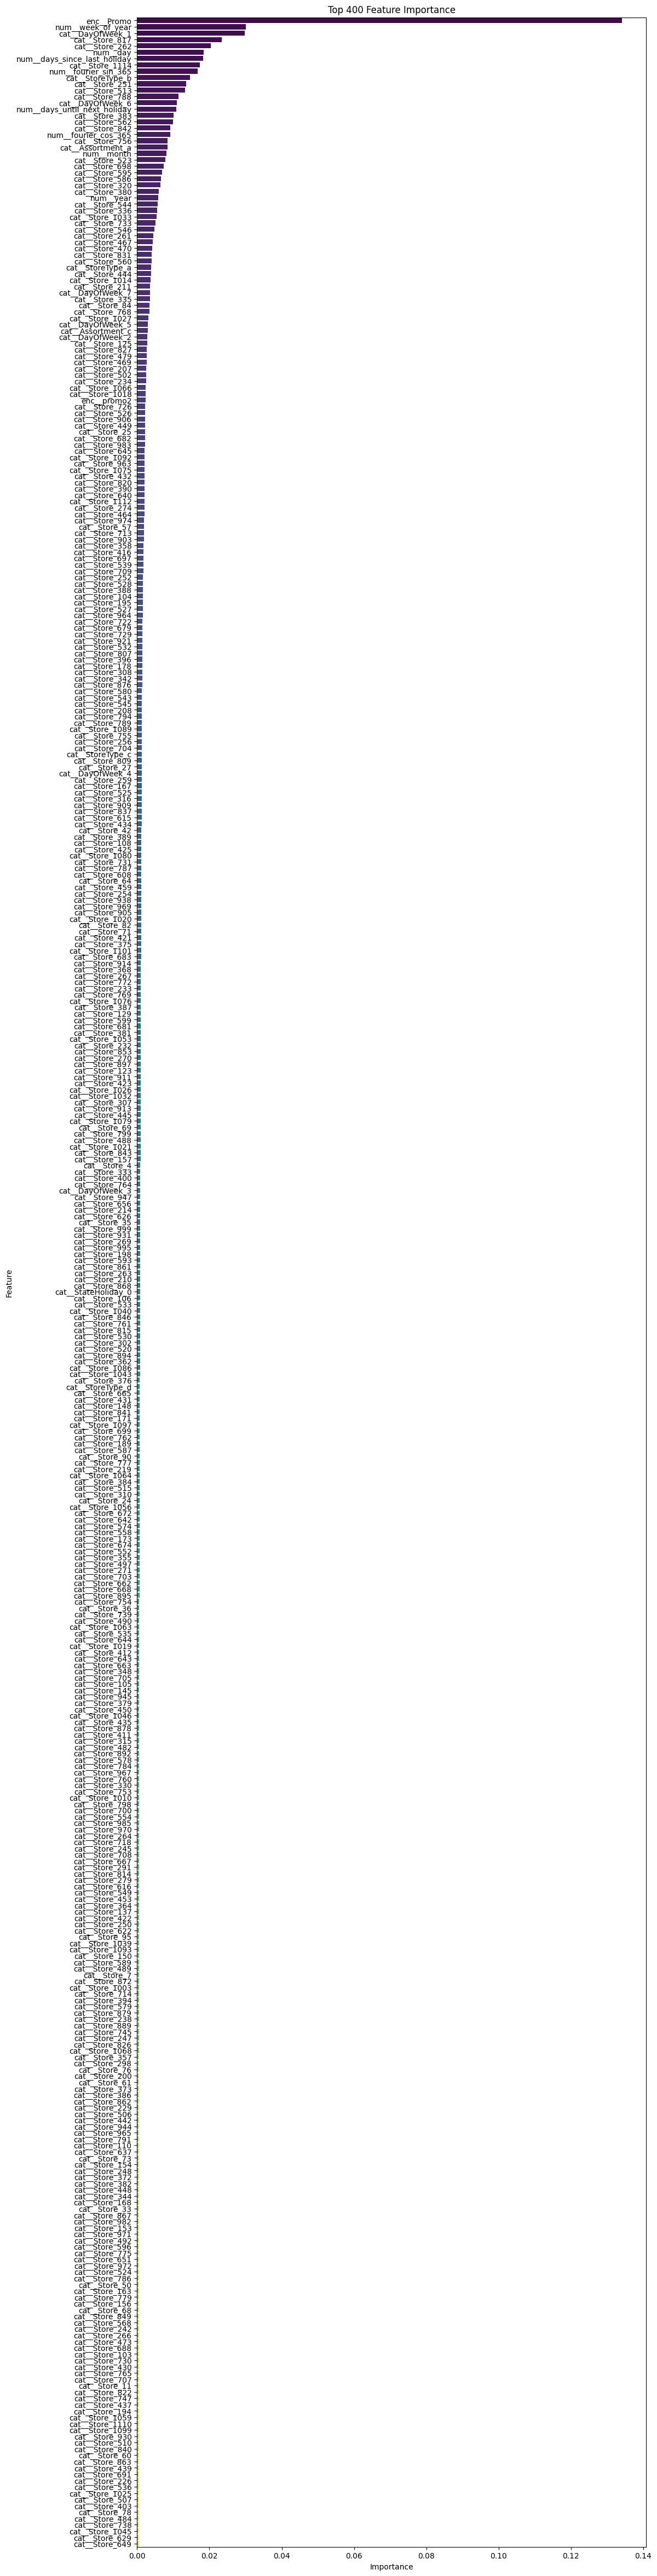

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns


# Sortiere die DataFrame nach 'Importance' und zeige nur die Top-n Features
feature_importance_df_2 = feature_importance_df.sort_values(by='Importance', ascending=False)[:400]

# Setze die Größe der Abbildung
plt.figure(figsize=(12,60))

# Erstelle das Balkendiagramm
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_2, palette='viridis')

# Füge Titel und Beschriftungen hinzu
plt.title('Top 400 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Rotieren der y-Achsenbeschriftungen, falls nötig
plt.yticks(rotation=0)

# Zeige das Diagramm an
plt.show()

# Hyperparameter tuning

Hyperparametertuning ist ein kritischer Schritt bei der Anwendung des **ExtraTreesRegressors**, der die Leistung des Modells erheblich beeinflussen kann. Die Wahl der richtigen Hyperparameter ist entscheidend, um die Vorhersagegenauigkeit zu maximieren und Overfitting zu verhindern.

#### Notwendigkeit des Hyperparametertunings

1. **Optimierung der Modellleistung**:
   Hyperparameter wie die Anzahl der Bäume (`n_estimators`), die maximale Tiefe der Bäume (`max_depth`) und die Mindestanzahl an Samples pro Blatt (`min_samples_leaf`) bestimmen die Struktur und Komplexität des Modells. Laut **Geurts et al. (2006)** kann eine ungenaue Auswahl dieser Parameter zu Überanpassung (Overfitting) oder Unteranpassung (Underfitting) führen. Eine gezielte Optimierung dieser Hyperparameter ist notwendig, um das optimale Gleichgewicht zwischen Bias und Varianz zu finden.

2. **Verbesserung der Vorhersagegenauigkeit**:
   Das Tuning von Hyperparametern kann signifikante Verbesserungen in der Modellgenauigkeit bewirken. **Biau et al. (2016)** haben gezeigt, dass gut abgestimmte Hyperparameter die Robustheit und Genauigkeit des ExtraTreesRegressors erhöhen, insbesondere in Szenarien mit komplexen Datenverteilungen und variablen Einflussfaktoren.

3. **Effiziente Nutzung von Ressourcen**:
   Hyperparametertuning ermöglicht es, die Rechenressourcen effizienter zu nutzen. Durch Methoden wie Grid Search oder Random Search können optimale Parameter schnell identifiziert werden, was die Trainingszeit reduziert und die Rechenlast minimiert (**Bergstra et al., 2011**).

#### Wichtige Hyperparameter und deren Einfluss

- **Anzahl der Bäume (`n_estimators`)**: Eine höhere Anzahl von Bäumen kann die Vorhersagegenauigkeit verbessern, erhöht jedoch auch die Rechenzeit. **Zhou et al. (2014)** betonen, dass eine optimale Anzahl von Bäumen zu einer besseren Generalisierung führt, ohne die Trainingszeit unverhältnismäßig zu verlängern.

- **Maximale Tiefe (`max_depth`)**: Diese Einstellung beeinflusst die Komplexität des Modells. Zu hohe Werte können zu Overfitting führen, während zu niedrige Werte die Fähigkeit des Modells einschränken, komplexe Muster zu erfassen. **Hutter et al. (2011)** weisen darauf hin, dass die Wahl der maximalen Tiefe entscheidend für die Erfassung der Datenstruktur ist.

- **Mindestanzahl an Samples pro Blatt (`min_samples_leaf`)**: Dieser Parameter kann helfen, Overfitting zu verhindern, indem er sicherstellt, dass jeder Entscheidungsweg in den Bäumen ausreichend Datenpunkte enthält. Laut **Feurer und Hutter (2019)** kann ein optimaler Wert für diesen Parameter die Modellstabilität verbessern.

#### Mögliche Methodiken für das Hyperparametertuning

- **Grid Search**: Diese Methode testet systematisch alle Kombinationen von Hyperparametern, was jedoch zeitaufwändig sein kann. **Bergstra et al. (2011)** empfehlen diese Methode, wenn die Anzahl der Hyperparameter und deren mögliche Werte überschaubar sind.

- **Optuna**: Optuna ist eine moderne Hyperparameteroptimierungsbibliothek, die auf adaptiver und effizienter Suche basiert. Sie verwendet eine innovative Strategie, die als Tree-Structured Parzen Estimator (TPE) bekannt ist, um vielversprechende Hyperparameterkombinationen zu identifizieren. Akiba et al. (2019) zeigen, dass Optuna in vielen Anwendungsfällen signifikante Vorteile hinsichtlich der Effizienz und Effektivität der Hyperparametertuning-Prozesse bietet. Die Flexibilität von Optuna ermöglicht auch die Integration komplexer Optimierungsprobleme und benutzerdefinierter Zielmetriken.


### Literaturverzeichnis

- Biau, G., & Scornet, E. (2016). A Random Forest Guided Tour. *Test*, 25(2), 197-227.
- Bergstra, J., & Bengio, Y. (2012). Random Search for Hyper-Parameter Optimization. *Journal of Machine Learning Research*, 13, 281-305.
- Feurer, M., & Hutter, F. (2019). Hyperparameter Optimization. In *Automated Machine Learning* (pp. 3-33). Springer.
- Geurts, P., Ernst, D., & Wehenkel, L. (2006). Extremely randomized trees. *Machine Learning*, 63(1), 3-42.
- Hutter, F., et al. (2011). Sequential Model-Based Optimization for General Algorithm Configuration. *LION*.
- Snoek, J., et al. (2012). Practical Bayesian optimization of machine learning algorithms. *NIPS*.
- Zhou, Z. H., & Li, M. (2014). Semi-Supervised Learning. *Springer*.

## Anzahl n_estimators

n_estimators: 1 - Train RMSPE: 0.2853, Test RMSPE: 0.2084
n_estimators: 5 - Train RMSPE: 0.2466, Test RMSPE: 0.1716
n_estimators: 10 - Train RMSPE: 0.2420, Test RMSPE: 0.1656
n_estimators: 20 - Train RMSPE: 0.2376, Test RMSPE: 0.1638


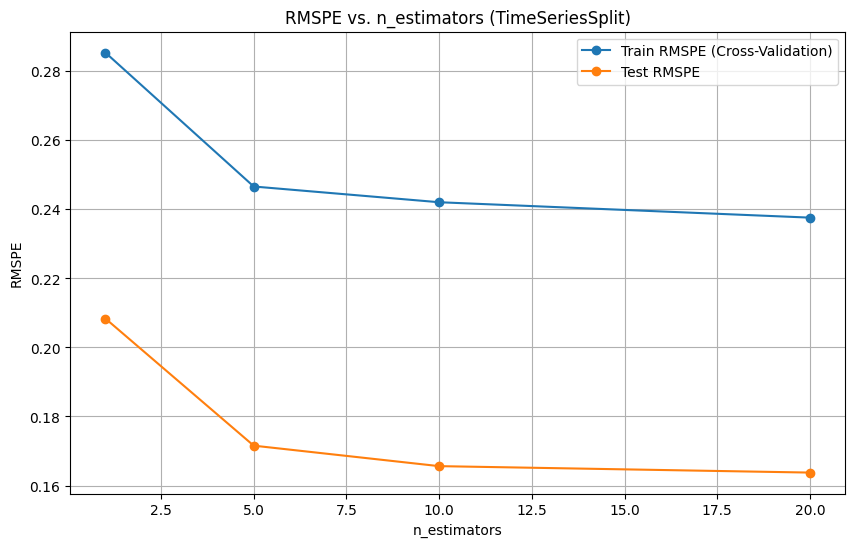

In [4]:
# Teste verschiedene Werte für n_estimators
n_estimators_range = [1, 5, 10, 20]
train_rmspe_scores = []
test_rmspe_scores = []

for n in n_estimators_range:
    # Erstelle die Pipeline mit dem aktuellen Wert für n_estimators
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators=n, random_state=42))
    ])
    
    # Cross-Validation auf dem Trainingsdatensatz durchführen
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer)
    mean_cv_score = -np.mean(cv_scores)  # Da RMSPE negativ definiert ist
    
    # Trainiere das Modell auf dem gesamten Trainingsdatensatz
    pipeline.fit(X_train, y_train)
    
    # Vorhersagen auf dem Testdatensatz
    y_test_pred = pipeline.predict(X_test)
    
    # Berechne RMSPE für den Testdatensatz
    test_rmspe = rmspe(y_test, y_test_pred)
    
    # Speichere die Scores
    train_rmspe_scores.append(mean_cv_score)
    test_rmspe_scores.append(test_rmspe)
    
    # Ausgabe der Ergebnisse
    print(f"n_estimators: {n} - Train RMSPE: {mean_cv_score:.4f}, Test RMSPE: {test_rmspe:.4f}")

# Plotten der Ergebnisse
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_rmspe_scores, label='Train RMSPE (Cross-Validation)', marker='o')
plt.plot(n_estimators_range, test_rmspe_scores, label='Test RMSPE', marker='o')
plt.xlabel('n_estimators')
plt.ylabel('RMSPE')
plt.title('RMSPE vs. n_estimators (TimeSeriesSplit)')
plt.legend()
plt.grid(True)
plt.show()

Unter Berücksichtigung des RMSPE-Wertes und der Laufzeit bei steigender Anzahl an Bäumen, liegt in diesem Fall der optimale Wert für `n_estimators` bei zehn. Dies liegt darin begründet, dass sich der RMSPE-Wert ab einem Wert von zehn Bäumen oder mehr nicht signifikant verbessert, die Laufzeit des Modells jedoch bei einem größeren `n_estimators`-Wert ansteigt. 

## GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV

# Teste verschiedene Werte für n_estimators, max_depth, min_samples_split
param_grid = {
    'model__n_estimators': [1, 5, 10],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10]
}

# Pipelineerstellung
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# GridSearchCV verwenden, um die besten Parameter zu finden
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring=rmspe_scorer, n_jobs=-1)

# Fitting auf den Trainingsdatensatz
grid_search.fit(X_train, y_train)

# Vorhersagen auf dem Trainings- und Testdatensatz
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

# Berechne RMSPE für Trainings- und Testdatensatz
train_rmspe = rmspe(y_train, y_train_pred)
test_rmspe = rmspe(y_test, y_test_pred)

# Ausgabe der Ergebnisse
print(f"Beste Parameter: {grid_search.best_params_}")
print(f"Train RMSPE: {train_rmspe:.4f}")
print(f"Test RMSPE: {test_rmspe:.4f}")

Beste Parameter: {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 10}
Train RMSPE: 0.1235
Test RMSPE: 0.1646


## Optuna

In [10]:
import optuna
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
import numpy as np

# Definiere die RMSPE-Funktion (Root Mean Squared Percentage Error)
def rmspe(y_true, y_pred):
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    return np.sqrt(np.mean(((y_true_filtered - y_pred_filtered) / y_true_filtered) ** 2))

# Scorer für die Cross-Validation
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

# Optuna-Ziel (Objective) für das Tuning
def objective(trial):
    # Hyperparameter, die durch Optuna optimiert werden
    n_estimators = trial.suggest_int('n_estimators', 1, 10)          # Anzahl der Bäume
    max_depth = trial.suggest_int('max_depth', 5, 50)                  # Maximale Tiefe der Bäume
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)  # Minimale Anzahl von Datenpunkten, um einen Split zu machen
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)    # Minimale Anzahl von Datenpunkten pro Blattknoten

    # Erstelle die Pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', ExtraTreesRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        ))
    ])
    
    # TimeSeriesSplit für zeitabhängige Daten
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Cross-Validation Score
    scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer)
    
    # Negativer RMSPE, da Optuna minimiert
    return -np.mean(scores)

# Starte die Optimierung
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Beste Parameter und Ergebnisse
print("Beste Parameter:", study.best_params)
print("Bester Score:", study.best_value)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-09-22 12:12:40,396] A new study created in memory with name: no-name-33ed54f0-818a-46d1-a4e9-9a0b78bee457
[I 2024-09-22 12:15:43,882] Trial 0 finished with value: 0.4355868057810806 and parameters: {'n_estimators': 5, 'max_depth': 40, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.4355868057810806.
[I 2024-09-22 12:16:51,255] Trial 1 finished with value: 0.4800996604532465 and parameters: {'n_estimators': 7, 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 12}. Best is trial 0 with value: 0.4355868057810806.
[I 2024-09-22 12:18:08,984] Trial 2 finished with value: 0.4511098930514118 and parameters: {'n_estimators': 3, 'max_depth': 35, 'min_samples_split':

KeyboardInterrupt: 

### Visualisierung

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Extrahiere die Parameter und die Zielwerte aus der Optuna-Studie
trials = study.trials_dataframe()

Die parallele Koordinatenvisualisierung stellt die Beziehungen zwischen mehreren Hyperparametern des ExtraTreesRegressors dar, wobei die Farbskala den RMSPE-Wert zeigt. Es zeigt, wie verschiedene Kombinationen der Hyperparameter die Modellleistung beeinflussen.

Der Verlauf der Optimierung illustriert den Fortschritt der Modellanpassung über die verschiedenen Trials hinweg, indem er die Entwicklung des RMSPE-Wertes in Abhängigkeit der Trial-Nummer anzeigt.

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Extrahiere die Parameter und die Zielwerte aus der Optuna-Studie
trials = study.trials_dataframe()

# Wähle relevante Parameter für den ExtraTreesRegressor aus
params = [
    'params_n_estimators', 
    'params_max_depth', 
    'params_min_samples_split', 
    'params_min_samples_leaf', 
    'params_max_features'
]
df = trials[params + ['value']]  # 'value' enthält die Objective-Werte (z.B. RMSPE)

# Erstelle eine parallele Koordinaten-Visualisierung
pd.plotting.parallel_coordinates(df, 'value', colormap='cool', alpha=0.3)
plt.title("Parallel Coordinates Plot für Optuna Trials (ExtraTreesRegressor)")
plt.xlabel("Hyperparameters")
plt.ylabel("Objective Value (RMSPE)")
plt.show()

# Visualisiere den Verlauf der Optimierung
plt.figure(figsize=(17, 6))
plt.plot(trials['number'], trials['value'], linestyle='-')
plt.xlabel('Trial Number')
plt.ylabel('Objective Value (RMSPE)')
plt.title('Optimierungsverlauf (RMSPE über Trials)')
plt.show()

KeyError: "['params_learning_rate', 'params_subsample', 'params_colsample_bytree'] not in index"

Die Scatter Plots zeigen die Beziehungen zwischen verschiedenen Hyperparameter-Paaren des ExtraTreesRegressors, während die Farbskala den RMSPE-Wert darstellt. Sie veranschaulichen, wie die Auswahl und Kombination dieser Hyperparameter die Modellleistung beeinflussen.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Liste der möglichen Parameterpaare, die du analysieren möchtest
parameter_pairs = [
    ('params_max_depth', 'params_n_estimators'),
    ('params_min_samples_split', 'params_n_estimators'),
    ('params_min_samples_leaf', 'params_max_depth'),
    ('params_max_features', 'params_n_estimators'),
    ('params_min_samples_leaf', 'params_min_samples_split')
]

# Schleife durch jedes Parameterpaar und erstelle einen Scatter Plot
for param_x, param_y in parameter_pairs:
    # Wähle zwei Hyperparameter und die Zielmetrik (RMSPE)
    df = trials[[param_x, param_y, 'value']].dropna()  # Entferne NaN-Werte

    # Extrahiere die Werte für die Achsen und die Zielmetrik
    x = df[param_x].values
    y = df[param_y].values
    z = df['value'].values

    # Erstelle den Scatter Plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(x, y, c=z, cmap='viridis', s=100)
    plt.colorbar(scatter, label='Objective Value (RMSPE)')
    
    # Achsenbeschriftungen und Titel setzen
    plt.xlabel(param_x)
    plt.ylabel(param_y)
    plt.title(f'Scatter Plot für {param_x} und {param_y}')
    
    # Zeige das Diagramm an
    plt.show()

Der Scatter Plot visualisiert die Beziehung zwischen der Anzahl der Bäume (`params_n_estimators`) und der maximalen Tiefe der Bäume (`params_max_depth`) im ExtraTreesRegressor, wobei die Farbskala den RMSPE-Wert darstellt, um die Auswirkungen dieser Hyperparameter auf die Modellleistung zu verdeutlichen.

In [ ]:
import matplotlib.pyplot as plt

# Wähle zwei Hyperparameter und die Zielmetrik aus
df = trials[['params_n_estimators', 'params_max_depth', 'value']]

# Erstelle den Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(df['params_n_estimators'], df['params_max_depth'], c=df['value'], cmap='viridis', s=100)
plt.colorbar(label='Objective Value (RMSPE)')
plt.xlabel('Number of Estimators')
plt.ylabel('Max Depth')
plt.title('Scatter Plot für Number of Estimators vs Max Depth')
plt.show()

# test

In [13]:
# Definiere die numerischen und kategorischen Features
numerical_features = ['month', 'day', 'week_of_year', 'fourier_sin_365', 'fourier_cos_365',	'days_since_last_holiday',	'days_until_next_holiday'] # lag_1, lag_7 entfernt

# Bereits encodierte Features
already_encoded_features = ['Promo', 'promo2']

# Noch nicht encodierte kategorische Features
categorical_features_to_encode = ['DayOfWeek', 'StoreType', 'StateHoliday','Assortment', 'Store']

# Erstelle den Preprocessor für numerische und kategorische Features (ohne Datumsextraktion)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Skalierung für numerische und bereits encodierte Features
        ('enc', 'passthrough', already_encoded_features),  # Bereits encodierte Features durchschleusen (keine weitere Transformation)
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_to_encode)  # Nur noch nicht encodierte Features encodieren
    ])

In [14]:
# Erstelle die Pipeline mit dem aktuellen Wert für n_estimators
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=7, max_depth=49, min_samples_split=13, min_samples_leaf=1, random_state=42, n_jobs=-1))
])

In [15]:
# Trainiere das Modell auf dem gesamten Trainingsdatensatz
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['month', 'day',
                                                   'week_of_year',
                                                   'fourier_sin_365',
                                                   'fourier_cos_365',
                                                   'days_since_last_holiday',
                                                   'days_until_next_holiday']),
                                                 ('enc', 'passthrough',
                                                  ['Promo', 'promo2']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DayOfWeek', 'StoreType',
                                                   'StateHoliday', 'Assortment',
                                                   'Store'])])),
                ('model',
                 RandomForestRegressor(n_estimators=1, n_jobs=-1,
                                       random_state=42))])

In [16]:
# Cross-Validation auf dem Trainingsdatensatz durchführen
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer)
mean_cv_score = -np.mean(cv_scores)  # Da RMSPE negativ definiert ist
print(mean_cv_score)

0.29521949007598713


In [17]:
# Vorhersagen auf dem Testdatensatz
y_test_pred = pipeline.predict(X_test)
# Berechne RMSPE für den Testdatensatz
test_rmspe = rmspe(y_test, y_test_pred)
print(test_rmspe)

0.21669623888784498


ExtraTreesRegressor

In [18]:
from sklearn.ensemble import ExtraTreesRegressor
# Erstelle die Pipeline mit dem aktuellen Wert für n_estimators
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ExtraTreesRegressor(n_estimators=7, max_depth=49, min_samples_split=13, min_samples_leaf=1, random_state=42, n_jobs=-1))
])

In [19]:
# Trainiere das Modell auf dem gesamten Trainingsdatensatz
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['month', 'day',
                                                   'week_of_year',
                                                   'fourier_sin_365',
                                                   'fourier_cos_365',
                                                   'days_since_last_holiday',
                                                   'days_until_next_holiday']),
                                                 ('enc', 'passthrough',
                                                  ['Promo', 'promo2']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DayOfWeek', 'StoreType',
                                                   'StateHoliday', 'Assortment',
                                                   'Store'])])),
                ('model',
                 ExtraTreesRegressor(max_depth=49, min_samples_split=13,
                                     n_estimators=7, n_jobs=-1,
                                     random_state=42))])

In [20]:
# Cross-Validation auf dem Trainingsdatensatz durchführen
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer)
mean_cv_score = -np.mean(cv_scores)  # Da RMSPE negativ definiert ist
print(mean_cv_score)

0.40396890708899474


In [21]:
# Vorhersagen auf dem Testdatensatz
y_test_pred = pipeline.predict(X_test)
# Berechne RMSPE für den Testdatensatz
test_rmspe = rmspe(y_test, y_test_pred)
print(test_rmspe)

0.34830258605982384


# test ende

# Finales Modell

In [22]:
# Definiere die numerischen und kategorischen Features
numerical_features = ['year', 'month', 'day', 'week_of_year', 'fourier_sin_365', 'fourier_cos_365',	'days_since_last_holiday',	'days_until_next_holiday'] # lag_1, lag_7 entfernt

# Bereits encodierte Features
already_encoded_features = ['Promo', 'promo2']

# Noch nicht encodierte kategorische Features
categorical_features_to_encode = ['DayOfWeek', 'StoreType', 'StateHoliday','Assortment', 'Store']

# Erstelle den Preprocessor für numerische und kategorische Features (ohne Datumsextraktion)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Skalierung für numerische und bereits encodierte Features
        ('enc', 'passthrough', already_encoded_features),  # Bereits encodierte Features durchschleusen (keine weitere Transformation)
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_to_encode)  # Nur noch nicht encodierte Features encodieren
    ])

In [23]:
# Erstelle die Pipeline mit dem aktuellen Wert für n_estimators
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=10, min_samples_split=5, max_depth=None, random_state=42, n_jobs=-1))
])

### Training

In [24]:
# Trainiere das Modell auf dem gesamten Trainingsdatensatz
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'month', 'day',
                                                   'week_of_year',
                                                   'fourier_sin_365',
                                                   'fourier_cos_365',
                                                   'days_since_last_holiday',
                                                   'days_until_next_holiday']),
                                                 ('enc', 'passthrough',
                                                  ['Promo', 'promo2']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DayOfWeek', 'StoreType',
                                                   'StateHoliday', 'Assortment',
                                                   'Store'])])),
                ('model',
                 RandomForestRegressor(min_samples_split=5, n_estimators=10,
                                       random_state=42))])

### Kreuzvalidierung - Timeseries

In [25]:
# Cross-Validation auf dem Trainingsdatensatz durchführen
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer)
mean_cv_score = -np.mean(cv_scores)  # Da RMSPE negativ definiert ist
print(mean_cv_score)

### Test

In [ ]:
# Vorhersagen auf dem Testdatensatz
y_test_pred = pipeline.predict(X_test)
# Berechne RMSPE für den Testdatensatz
test_rmspe = rmspe(y_test, y_test_pred)
print(test_rmspe)

### Visualisierung der Performance des Modells

Lernkurven zeigen typischerweise zwei Hauptmetriken: den Trainingsfehler und den Testfehler in Abhängigkeit von der Anzahl der verwendeten Trainingsbeispiele. Diese Visualisierung ist entscheidend, um festzustellen, wie gut ein Modell mit den verfügbaren Daten arbeitet. Sie ermöglichen es Überanpassung (Overfitting), Unteranpassung (Underfitting) und Datenbedarf zu bewerten.

1. **Überanpassung (Overfitting)**: Wenn der Trainingsfehler niedrig und der Testfehler hoch ist, deutet dies auf ein Überanpassungsproblem hin. Das Modell hat die Trainingsdaten zu gut erlernt, was zu einer schlechten Generalisierung auf unbekannte Daten führt (Zhou et al., 2012).

2. **Unteranpassung (Underfitting)**: Ein hohes Maß an Fehler sowohl im Training als auch im Test weist auf ein Unteranpassungsproblem hin. In diesem Fall ist das Modell nicht in der Lage, die zugrunde liegenden Muster der Daten zu erfassen (James et al., 2013).

3. **Datenbedarf**: Die Lernkurve kann auch aufzeigen, ob das Modell von mehr Trainingsdaten profitieren würde. Ein stetiger Rückgang des Testfehlers mit zunehmender Datenmenge kann darauf hindeuten, dass mehr Daten erforderlich sind, um die Leistung zu verbessern (Bengio et al., 2012).

Die Funktion `learning_curve` aus dem Modul `sklearn.model_selection` dient der Erstellung einer solchen Lernkurven.

### Literaturverzeichnis

- Bengio, Y., et al. (2012). Learning Deep Architectures for AI. *Foundations and Trends in Machine Learning*, 2(1), 1-127.
- James, G., et al. (2013). *An Introduction to Statistical Learning*. Springer.
- Zhou, Z. H., & Li, M. (2012). Semi-Supervised Learning. *Springer*.

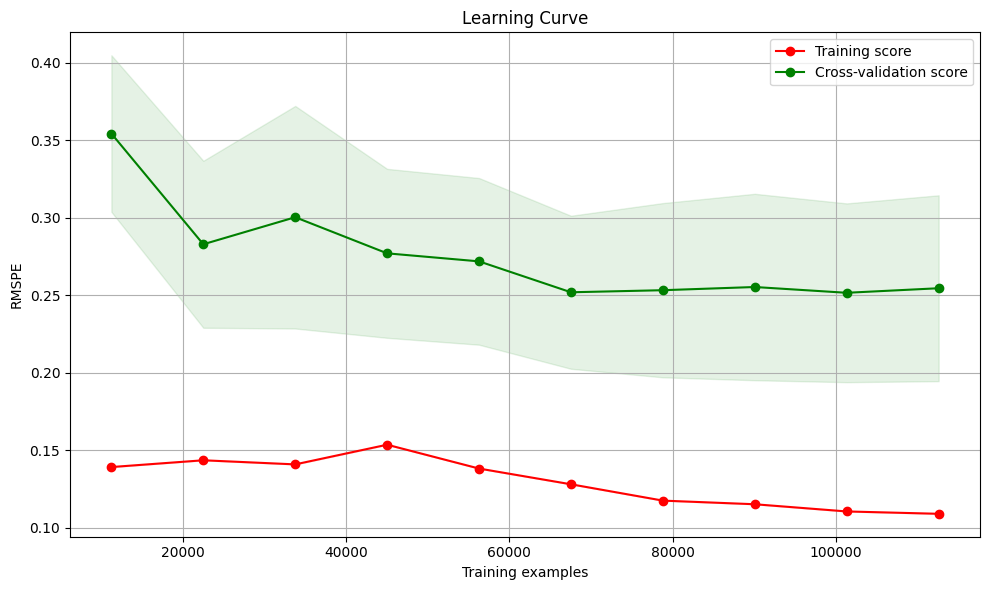

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer, train_sizes=np.linspace(0.1, 1.0, 10))

# Berechne die mittleren und Standardabweichungen der Scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot der Lernkurve
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("RMSPE")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


Die folgende Abbildung visualisiert die tatsächlichen Verkaufszahlen (`y_test`) und die Vorhersagen (`y_pred`) für ausgewählte Stores über die Zeit. Die X-Achse zeigt die Datumsangaben und die Y-Achse die Verkaufszahlen. Hierdurch wird der Vergleich der Modellvorhersagen mit den realen Verkaufsdaten für die gewählten Stores ermöglicht.

Training RMSPE: 0.12351592698379357
Test RMSPE: 0.1645833774723826


/var/folders/k5/dycty0m90m93hgc19mfyrsrr0000gn/T/ipykernel_83592/808887278.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Date'] = pd.to_datetime(X_test['Date'], errors='coerce')  # Konvertiere in Datetime, Fehler werden als NaT behandelt


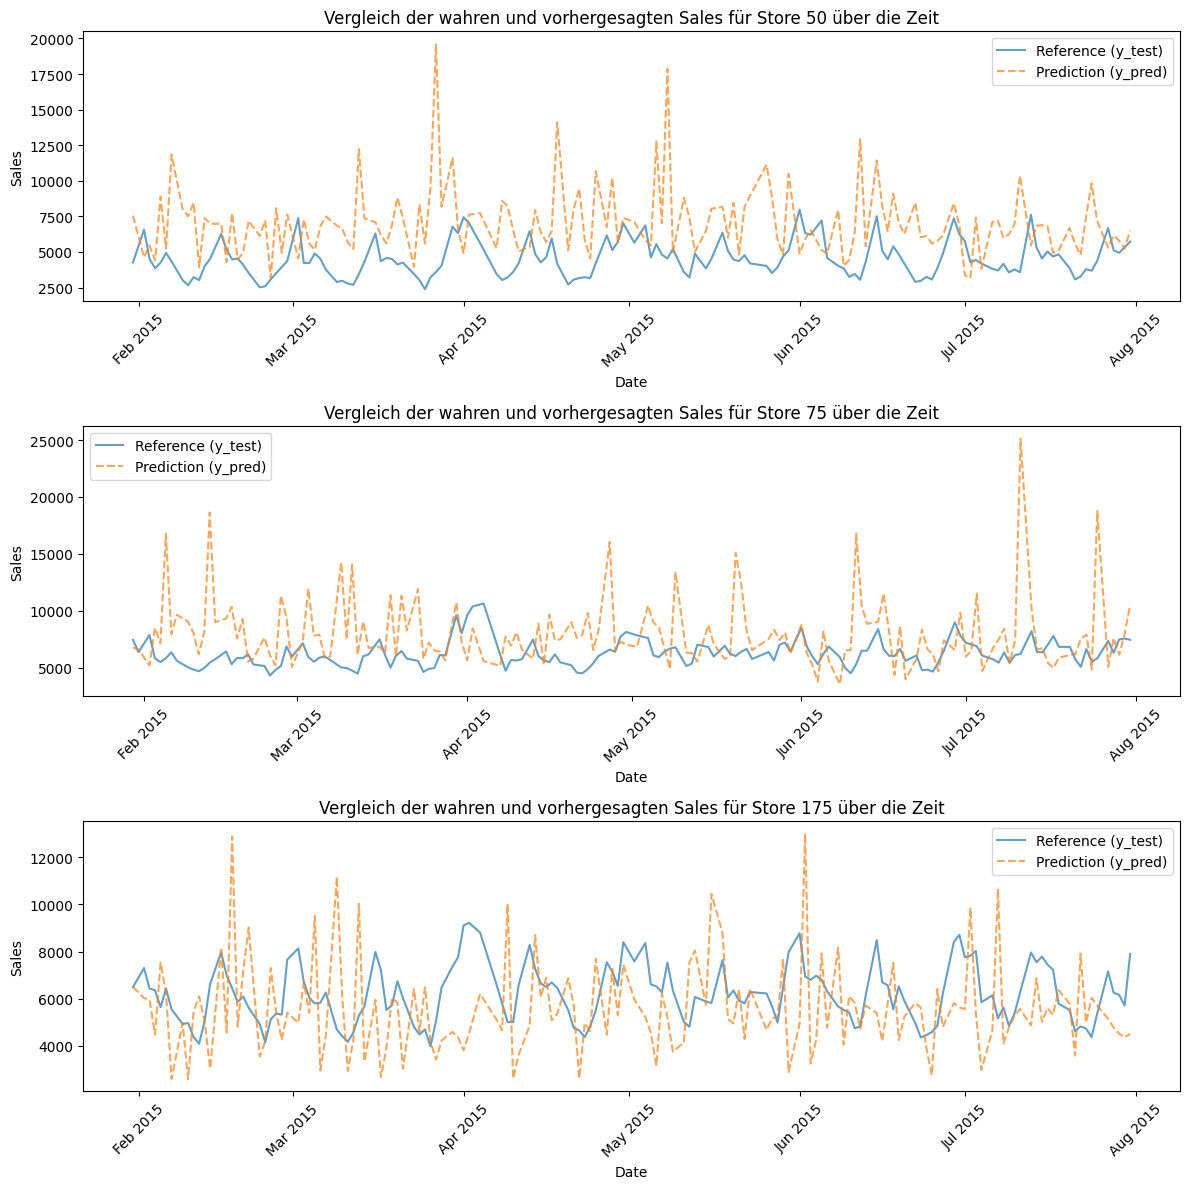

In [62]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np

# Vorhersagen auf den Trainingsdaten
y_train_pred = pipeline.predict(X_train)

# Vorhersagen auf den Testdaten
y_test_pred = pipeline.predict(X_test)

# Berechne den RMSPE auf den Trainings- und Testdaten
train_rmspe = rmspe(y_train, y_train_pred)
test_rmspe = rmspe(y_test, y_test_pred)

print(f'Training RMSPE: {train_rmspe}')
print(f'Test RMSPE: {test_rmspe}')

# Konvertiere die 'Date'-Spalte in ein Datetime-Format
X_test['Date'] = pd.to_datetime(X_test['Date'], errors='coerce')  # Konvertiere in Datetime, Fehler werden als NaT behandelt

# Liste der Stores, die du visualisieren möchtest
store_list = [50, 75, 175]  # Beispiel: Stores 1, 2, 3

# Anzahl der Subplots festlegen
num_stores = len(store_list)
fig, axes = plt.subplots(num_stores, 1, figsize=(12, 4 * num_stores))

if num_stores == 1:
    axes = [axes]  # Falls nur ein Store, damit axes immer iterierbar ist

# Schleife über die verschiedenen Stores
for i, store in enumerate(store_list):
    # Filtern der Testdaten für den aktuellen Store
    store_test_data = X_test[X_test['Store'] == store]
    store_y_test = y_test[store_test_data.index]
    
    # Indizes herausfinden
    store_indices = store_test_data.index
    
    # Vorhersagen für diese Indizes extrahieren
    store_y_pred = y_test_pred[store_indices - X_test.index.min()]
    
    # Sortieren nach Datum
    store_test_data = store_test_data.sort_values('Date')
    store_y_test = store_y_test[store_test_data.index]
    store_y_pred = store_y_pred[np.argsort(store_test_data['Date'].values)]
    
    # Plotten für den aktuellen Store
    axes[i].plot(store_test_data['Date'], store_y_test, label='Reference (y_test)', linestyle='-', marker='', alpha=0.7)
    axes[i].plot(store_test_data['Date'], store_y_pred, label='Prediction (y_pred)', linestyle='--', marker='', alpha=0.7)
    
    # X-Achsen Formatierung: Nur einmal pro Monat anzeigen
    axes[i].xaxis.set_major_locator(mdates.MonthLocator())  # Monatliche Ticks
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Nur Monat und Jahr anzeigen
    
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Sales')
    axes[i].set_title(f'Vergleich der wahren und vorhergesagten Sales für Store {store} über die Zeit')
    axes[i].legend()
    axes[i].tick_params(axis='x', rotation=45)  # X-Achse drehen, um die Daten lesbar zu machen

# Layout anpassen, damit sich die Subplots nicht überlappen
plt.tight_layout()
plt.show()

Der Residuenplot stellt die Residuen (Fehler) gegen die tatsächlichen Verkaufszahlen für einen bestimmten Store dar. Die horizontale Linie bei Null dient als Referenz. Es können systematische Fehler im Modell erkannt werden, indem aufgezeigt wird, ob die Residuen zufällig verteilt sind oder ob es Muster gibt, die auf unmodellierte Einflüsse hindeuten.

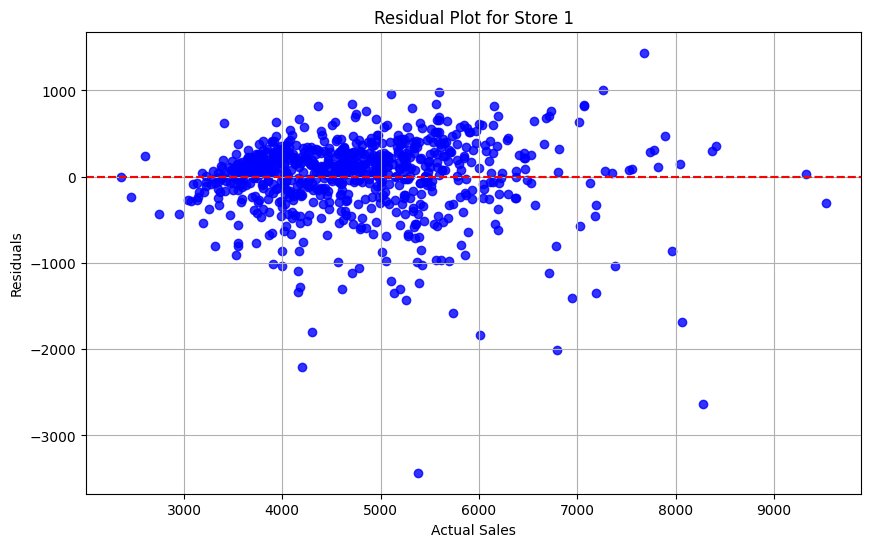

In [52]:
import seaborn as sns
# Residuals berechnen
results['Residuals'] = results['Actual Sales'] - results['Predicted Sales']

# Residual Plot ohne Lowess
plt.figure(figsize=(10, 6))
sns.residplot(x=results['Actual Sales'], y=results['Residuals'], color="blue")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Sales')
plt.ylabel('Residuals')
plt.title(f'Residual Plot for Store {store_id}')
plt.grid(True)
plt.show()



Die Abbildung zeigt die Verteilung der Residuen für einen bestimmten Store in einem Histogramm mit einer überlagerten Dichtekurve, wodurch die Streuung und zentrale Tendenz der Fehler zwischen den tatsächlichen und prognostizierten Verkaufszahlen erkennbar gemacht werden. Diese Analyse ermöglicht es, die Homogenität und Normalverteilung der Residuen zu überprüfen, was wichtige Hinweise auf die Modellgüte liefert.

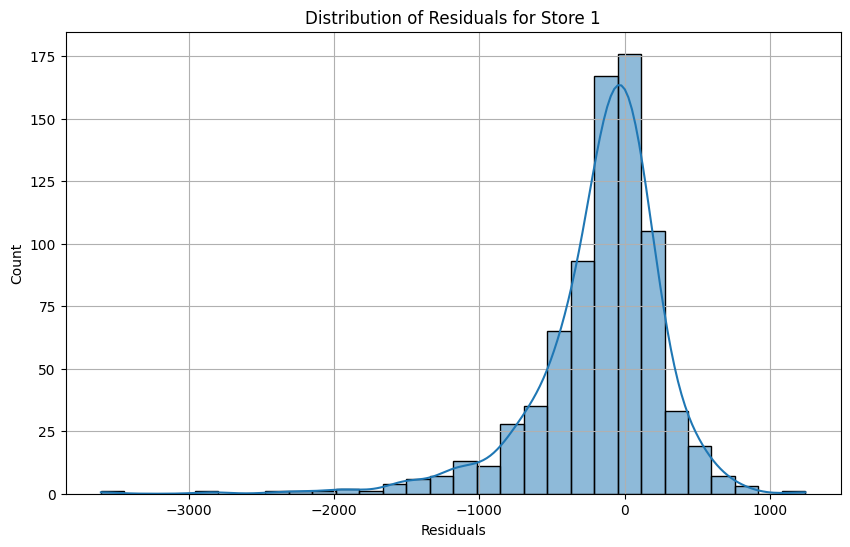

In [53]:
plt.figure(figsize=(10, 6))
sns.histplot(results['Residuals'], kde=True, bins=30)
plt.xlabel('Residuals')
plt.title(f'Distribution of Residuals for Store {store_id}')
plt.grid(True)
plt.show()


Die Abbildung visualisiert die kumulierten Verkaufszahlen für einen bestimmten Store, indem die tatsächlichen (`Cumulative Actual Sales`) und die prognostizierten Verkaufszahlen (`Cumulative Predicted Sales`) über die Zeit dargestellt werden. Dies sorgt für einen klaren Vergleich der Gesamtentwicklung der Verkaufszahlen und veranschaulicht die Leistungsfähigkeit des Modells über den betrachteten Zeitraum hinweg.

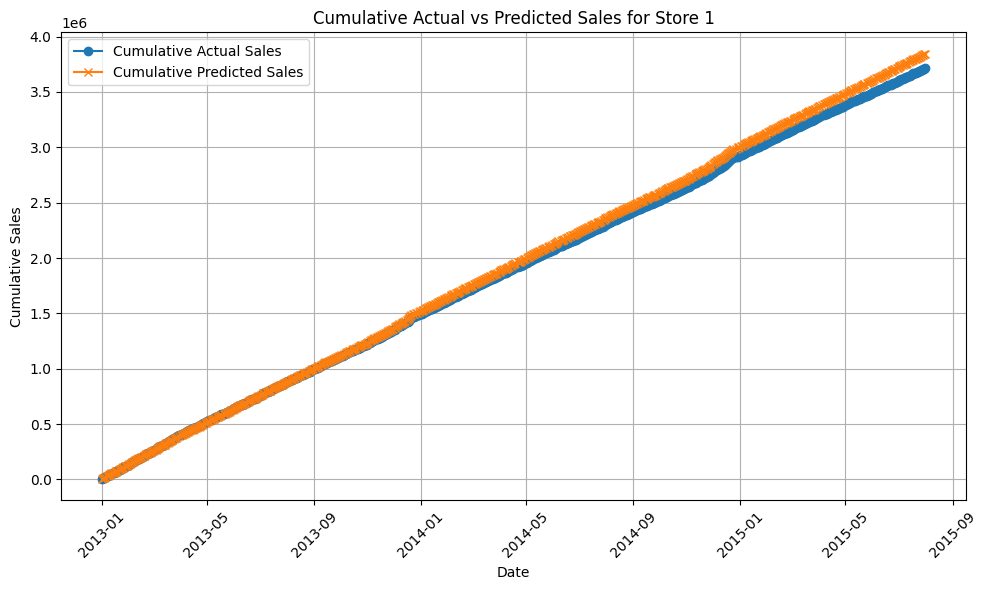

In [56]:
# Kumulierte Verkaufszahlen berechnen
results['Cumulative Actual Sales'] = results['Actual Sales'].cumsum()
results['Cumulative Predicted Sales'] = results['Predicted Sales'].cumsum()

# Plot kumulierter Verkaufszahlen
plt.figure(figsize=(10, 6))
plt.plot(results['Date'], results['Cumulative Actual Sales'], label='Cumulative Actual Sales', marker='o')
plt.plot(results['Date'], results['Cumulative Predicted Sales'], label='Cumulative Predicted Sales', marker='x')

plt.xlabel('Date')
plt.ylabel('Cumulative Sales')
plt.title(f'Cumulative Actual vs Predicted Sales for Store {store_id}')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Die folgende Abbildung aggregiert die Residualwerte pro Woche und visualisiert diese in einem Balkendiagramm, das die mittleren wöchentlichen Fehler für einen bestimmten Store darstellt. Hierdurch werden zeitliche Muster in den Vorhersagefehlern erkennbar gemacht und es werden potenzielle Schwankungen in der Modellgenauigkeit über die verschiedenen Wochen des Jahres hervorgehoben.

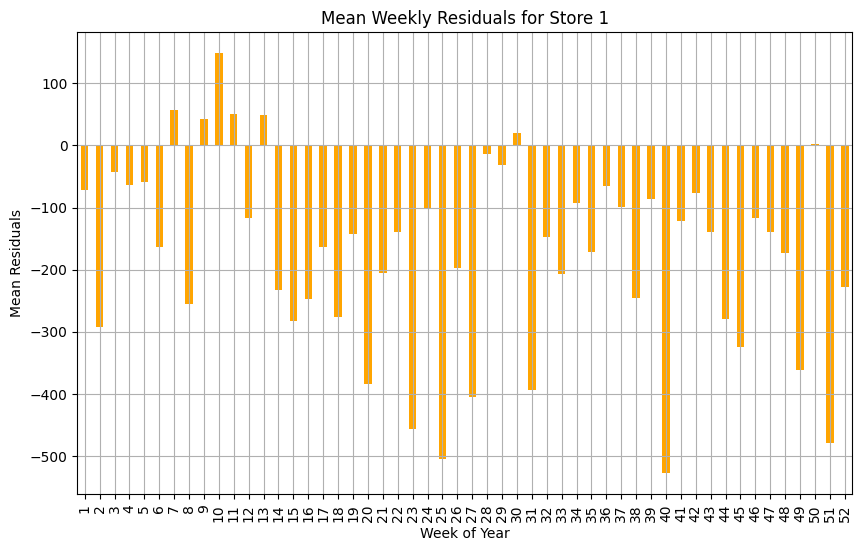

In [58]:
# Fehler pro Woche aggregieren
results['week_of_year'] = results['Date'].dt.isocalendar().week
weekly_errors = results.groupby('week_of_year')['Residuals'].mean()

# Balkendiagramm der mittleren wöchentlichen Fehler
plt.figure(figsize=(10, 6))
weekly_errors.plot(kind='bar', color='orange')
plt.xlabel('Week of Year')
plt.ylabel('Mean Residuals')
plt.title(f'Mean Weekly Residuals for Store {store_id}')
plt.grid(True)
plt.show()


Das Streudiagramm visualisiert die tatsächlichen Verkaufszahlen gegen die prognostizierten Verkaufszahlen für einen bestimmten Store. Die hinzugefügte diagonale Linie (rote gestrichelte Linie) dient als Referenz für ideale Vorhersagen, wodurch Abweichungen zwischen den tatsächlichen und den prognostizierten Werten sichtbar werden und die Genauigkeit des Modells bewertet werden kann.

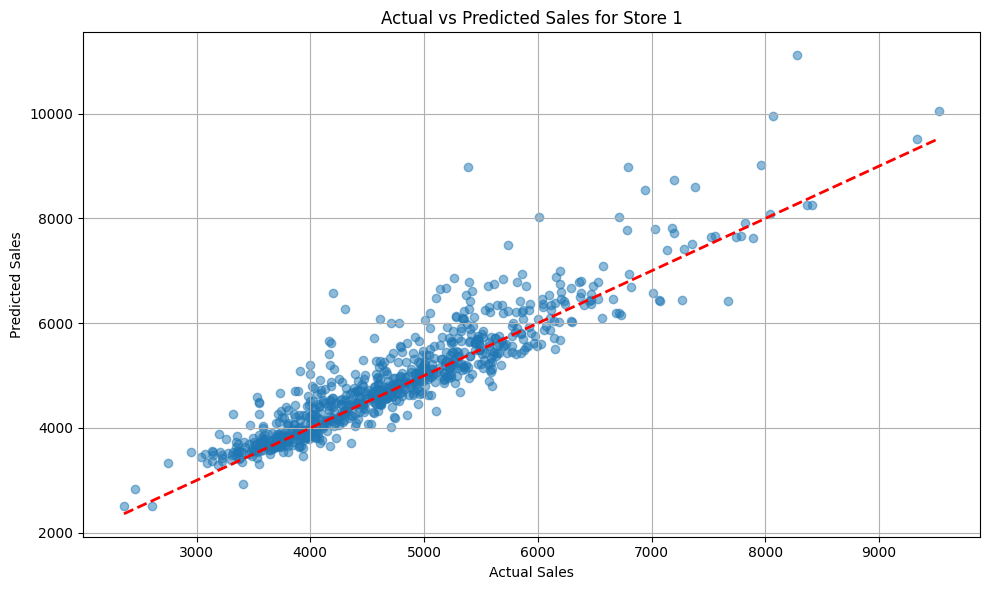

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(y_store, y_store_pred, alpha=0.5)
plt.plot([y_store.min(), y_store.max()], [y_store.min(), y_store.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title(f'Actual vs Predicted Sales for Store {store_id}')
plt.grid(True)

plt.tight_layout()
plt.show()
